## Data Comparison in PRE-SWOT region

#### Importing needed libraries

Define the paths for the files

In [1]:
from defaults import *

scrip.so not found. Remapping function will not be available


Open all the files

In [2]:
ds_pool = {'WMOPv2.0': get_wmop_output_dataset('WMOP2.0_FORECAST',date_suffix='*20180*[5][0-9][1-8]') ,
            'WMOPv2.0 with Assimilation': get_wmop_output_dataset('WMOP2.0_FORECAST_ASSIM',date_suffix='*20180*[5][0-9][1-8]',),
            'WMOPv3.0 with Nesting': get_wmop_output_dataset('WMOP3.0_NESTING_PRESWOT_D',date_suffix='*20180*[5][0-9][1-8]')}


/mnt/waverider/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_MFS/forecast_scratch/*20180*[5][0-9][1-8]_avg.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_MFS_ASSIM/forecast_scratch/*20180*[5][0-9][1-8]_avg.nc
/mnt/waverider/data/WMOP/WMOP_FORECAST_preop/Outputs/FORECAST_MFS_WMOPv3.0_PRE-SWOT_nesting/forecast_scratch/*20180*[5][0-9][1-8]_avg.nc


In [3]:
ProgressBar().register()

### Kinetic Energy

In [4]:
@vectorize([float64(float64, float64)])
def compute_ke(u,v):
    tke = ((u)**2+(v)**2)/2
    return tke

In [5]:
def get_ke_from_uv(u,v,subtract_mean=False):
    u_psi = (u.loc[:,:,1:,:]+u.loc[:,:,:-1,:])/2
    v_psi = (v.loc[:,:,:,1:]+v.loc[:,:,:,:-1])/2
    u_psi = u_psi.rename({'eta_u': 'eta_psi','xi_u': 'xi_psi'})
    v_psi = v_psi.rename({'eta_v': 'eta_psi','xi_v': 'xi_psi'})
    if subtract_mean:
        u_anomaly = u_psi - u_psi.mean('ocean_time')
        v_anomaly = v_psi - v_psi.mean('ocean_time')
        return compute_ke(u_anomaly,v_anomaly)
    else:
        return compute_ke(u_psi,v_psi)

#### Total Kinetic Energy 

In [6]:
ke_pool = xr.concat([get_ke_from_uv(ds.u,ds.v).isel(s_rho=-1).mean(['ocean_time']) for name,ds in ds_pool.items()], dim='type')

In [7]:
ke_pool.coords["type"] = list(ds_pool.keys())

[########################################] | 100% Completed | 31.1s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s


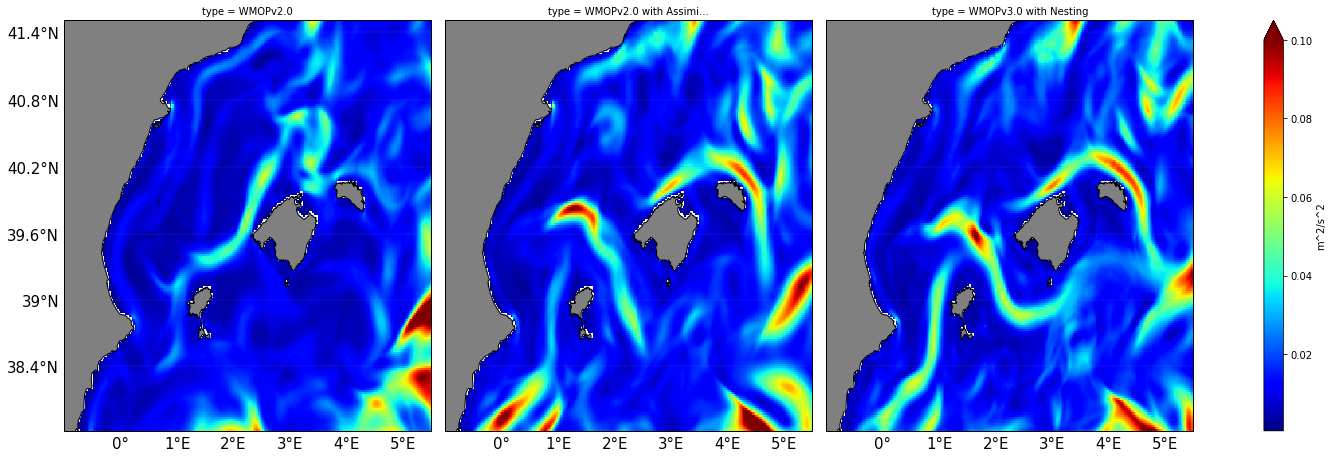

In [8]:
fc = ke_pool.plot(figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_u', y='lat_v',vmax=0.1,cmap='jet',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True,)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands',ax=ax,drawy=(i==0))
fc.cbar.set_label('m^2/s^2')

### Salinity

In [25]:
ssh_pool = xr.concat([ds.salt.mean(['ocean_time']).isel(s_rho=-1) for name,ds in ds_pool.items()], dim='type')

In [26]:
ssh_pool.coords["type"] = list(ds_pool.keys())

[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s


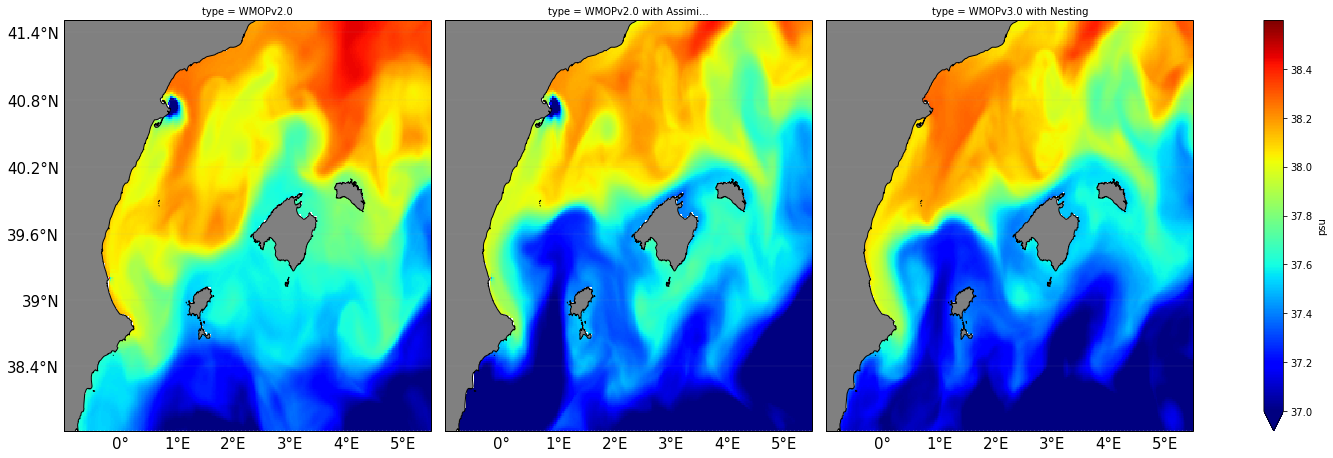

In [32]:
fc = ssh_pool.plot(figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',cmap='jet',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True,vmin=37)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands',ax=ax,drawy=(i==0))
fc.cbar.set_label('psu')
#fc.fig.subplots_adjust(top=0.9)
#fc.fig.suptitle('THIS IS A TITLE, YOU BET',fontsize=20)

### Circulation and Salinity

In [12]:
u_pool =  [pyroms.utility.move2grid(ds.isel(s_rho=-1).mean(['ocean_time']).u,'u','psi') for name,ds in ds_pool.items()]
v_pool =  [pyroms.utility.move2grid(ds.isel(s_rho=-1).mean(['ocean_time']).v,'v','psi') for name,ds in ds_pool.items()]

In [18]:
lon_psi = ds_pool['WMOPv2.0 with Assimilation'].lon_psi.values
lat_psi = ds_pool['WMOPv2.0 with Assimilation'].lat_psi.values

[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.4s


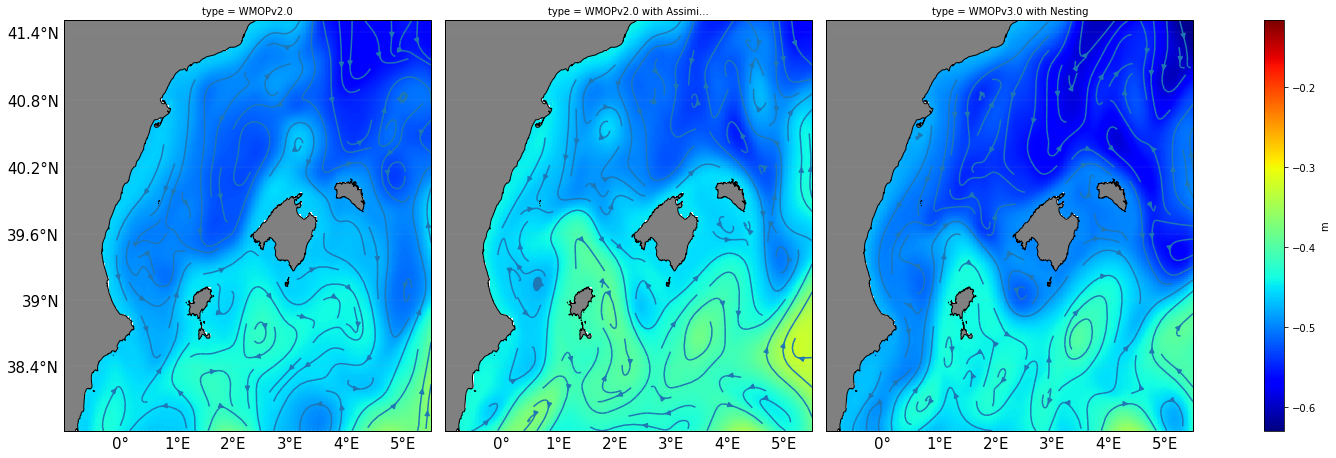

In [19]:
fc = ssh_pool.plot(figsize=[20,6],transform=dtr(),sharey=True,col='type',x='lon_rho', y='lat_rho',cmap='jet',subplot_kws={'projection':ccrs.Mercator()},add_colorbar=True,)
for i,ax in enumerate(fc.axes[0,:]):
    draw_background_map('BalearicIslands',ax=ax,drawy=(i==0))
    ax.streamplot(lon_psi, lat_psi,u_pool[i].values,v_pool[i].values,transform=dtr())
fc.cbar.set_label('m')
#fc.fig.subplots_adjust(top=0.9)
#fc.fig.suptitle('THIS IS A TITLE, YOU BET',fontsize=20)

In [15]:
sla_ds = xr.open_mfdataset('/mnt/waverider/data/Data/Observations/ALTIMETRY/nrt_map_sla/2018/05/*')

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


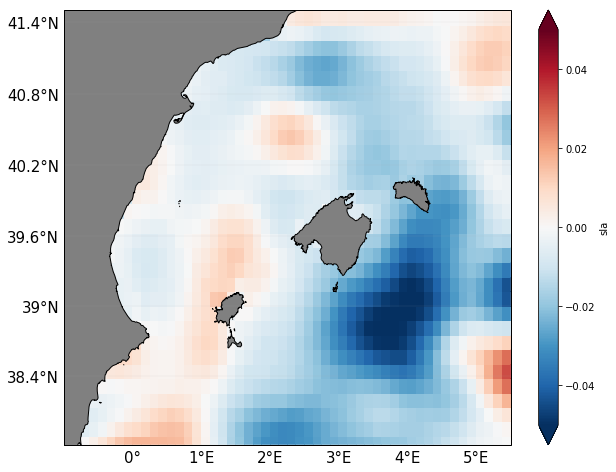

In [31]:
fig, ax = draw_background_map('BalearicIslands')
sla_ds.sla.mean('time').plot(ax=ax,transform=dtr(),vmax=0.05)

In [ ]:
sla = sla_ds.sla.mean('time')

In [ ]:
sla

In [ ]:
xr.concat([ds_pool['WMOPv2.0 with Assimilation'].zeta.mean('ocean_time'),sla_ds.sla.mean('time')], dim='type')